# Processing Big Data - Data profiling

© Explore Data Science Academy

## Honour Code
I {SIPHO, SHIMANGE}, confirm - by submitting this document - that the solutions in this notebook are a result of my own work and that I abide by the [EDSA honour code](https://drive.google.com/file/d/1QDCjGZJ8-FmJE3bZdIQNwnJyQKPhHZBn/view?usp=sharing).
    Non-compliance with the honour code constitutes a material breach of contract.

## Context

Having completed the first step - data ingestion, the data now needs to be thoroughly prepared so that it is readable, reliable and robust. As the Data Engineer in the team, this will be your responsibility. The Data Scientists are looking to you to clean this data so that model development and deployment become seamless when the data is used in a production environment. Having completed your Data Engineering course recently, your manager Gnissecorp Atadgid, asks you to create data summaries and perform checks using the six dimensions of data quality.

<div align="center" style="width: 600px; font-size: 80%; text-align: center; margin: 0 auto">
<img src="https://github.com/Explore-AI/Pictures/raw/master/data_engineering/transform/predict/DataQuality.jpg"
     alt="Data Quality"
     style="float: center; padding-bottom=0.5em"
     width=100%/>
     <p><em>Figure 1. Six dimensions of data quality</em></p>
</div>

## Import libraries
Below we import the libraries required to complete this section of the predict.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *

Remember that we need a `SparkContext` and `SparkSession` to interface with Spark.
We will mostly be using the `SparkContext` to interact with RDDs 
and the `SparkSession` to interface with Python objects.

> ℹ️ **Instructions** ℹ️
>
>Initialise a new **Spark Context** and **Session** that you will use to interface with Spark.

In [2]:
sc = SparkContext.getOrCreate()
sc

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/07/20 07:53:03 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


<SparkContext master=local[*] appName=pyspark-shell>

In [3]:
spark = SparkSession(sc)
spark

## Parquet files
In the previous section of the predict, you generated parquet files to your local directory. You will be making use of these files to continue with this section of the predict. Please make sure that your parquet files are specifically for the year **1962**. Any other year used outside of **1962** will produce incorrect answers and have a negative impact on your overall predict mark.

> ℹ️ **Instructions** ℹ️
>
> Read the parquet files stored in your directory for the year **1962** into a Spark DataFrame.

In [4]:
def read_parquet_file(path):
    try:
        df = spark.read.parquet(path)
        return df
    except FileNotFoundError as e:
            print(f'Folder not found: Error {e}')

In [5]:
path_1962 = '../output'
df_parquet = read_parquet_file(path_1962)
df_parquet.describe().show(truncate=False)

24/07/20 07:53:38 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------+------------------+------------------+-----------------+-----------------+-----------------+-----+
|summary|open              |high              |low               |close            |adj_close        |volume           |stock|
+-------+------------------+------------------+------------------+-----------------+-----------------+-----------------+-----+
|count  |5106              |5106              |5064              |5106             |5085             |5085             |5106 |
|mean   |1.0904873526012002|16.757624946793637|15.728619917198033|16.64199179044607|5.986642513535306|540930.2458210423|NULL |
|stddev |2.36445352530491  |53.91407348193546 |51.32292289814399 |53.54677139900802|24.64637054715319|864596.2440525505|NULL |
|min    |0.0               |0.0               |0.052377883       |0.053624976      |4.0381454E-7     |0                |AA   |
|max    |20.0              |287.5             |282.5             |285.0            |127.45936        |19545600 

In [5]:
df_parquet.printSchema()

root
 |-- date: date (nullable = true)
 |-- open: float (nullable = true)
 |-- high: float (nullable = true)
 |-- low: float (nullable = true)
 |-- close: float (nullable = true)
 |-- adj_close: float (nullable = true)
 |-- volume: integer (nullable = true)
 |-- stock: string (nullable = true)



## Metadata 

Metadata is data containing additional information about the data itself. In the cloud storage, there is a metadata file called [`symbols_valid_meta.csv`](https://processing-big-data-predict-stocks-data.s3.eu-west-1.amazonaws.com/symbols_valid_meta.csv) that is collocated with the stock market data. You will need to download this to use when performing your data quality checks.

> ℹ️ **Instructions** ℹ️
>
> Download the metadata from the S3 bucket and read it into a Spark DataFrame.

In [6]:
def read_metadata(path):
    try:
        df = spark.read.csv(path, header=True)
        return df
    except FileNotFoundError as e:
            print(f'Folder not found: Error {e}')


In [8]:
metadata_path = '../symbols_valid_meta.csv'
metadata = read_metadata(metadata_path)
metadata.show(10)

+-------------+------+--------------------+----------------+---------------+---+--------------+----------+----------------+----------+-------------+----------+
|Nasdaq Traded|Symbol|       Security Name|Listing Exchange|Market Category|ETF|Round Lot Size|Test Issue|Financial Status|CQS Symbol|NASDAQ Symbol|NextShares|
+-------------+------+--------------------+----------------+---------------+---+--------------+----------+----------------+----------+-------------+----------+
|            Y|     A|Agilent Technolog...|               N|               |  N|         100.0|         N|            NULL|         A|            A|         N|
|            Y|    AA|Alcoa Corporation...|               N|               |  N|         100.0|         N|            NULL|        AA|           AA|         N|
|            Y|  AAAU|Perth Mint Physic...|               P|               |  Y|         100.0|         N|            NULL|      AAAU|         AAAU|         N|
|            Y|  AACG|ATA Creativity Gl.

## Data Accuracy
Data accuracy is the degree to which data correctly describes a "real world" object or event.

It is important to do checks to determine the basic integrity of the dataset; do the values fall within expected ranges?

Most of the possible errors relating to data accuracy can occur at collection time. In our case, it is not possible to test the collection time accuracy, so we have to infer from ranges and summary statistics. Here you need to look closely at each field to see if its values make sense, with no strange surprises.

In assessing accuracy, it is important to look into precision as well. Do you need seven decimals, or will one or two suffice?

- **Measured by**: The degree to which the data mirrors the characteristics of the real-world object or objects it represents;
- **Units**: The percentage of data entries that pass the data accuracy rules;
- **Related to**: Validity, Uniqueness, Consistency.

> ℹ️ **Instructions** ℹ️
>
> Generate summary statistics to explore your data. Make sure you understand the ranges, means, extremums, and deviations found in the data set.

In [8]:
df_parquet.describe().show()

+-------+------------------+------------------+------------------+-----------------+-----------------+-----------------+-----+
|summary|              open|              high|               low|            close|        adj_close|           volume|stock|
+-------+------------------+------------------+------------------+-----------------+-----------------+-----------------+-----+
|  count|              5106|              5106|              5064|             5106|             5085|             5085| 5106|
|   mean|1.0904873526012002|16.757624946793637|15.728619917198033|16.64199179044607|5.986642513535306|540930.2458210423| NULL|
| stddev|  2.36445352530491| 53.91407348193546| 51.32292289814399|53.54677139900802|24.64637054715319|864596.2440525505| NULL|
|    min|               0.0|               0.0|       0.052377883|      0.053624976|     4.0381454E-7|                0|   AA|
|    max|              20.0|             287.5|             282.5|            285.0|        127.45936|         

> ℹ️ **Instructions** ℹ️
>
> Generate histograms for the six numerical attributes found in the data to understand the distribution of values.
>
>*You may use as many coding cells as necessary.*

In [13]:
def generate_multi_hist(df, columns):
    for column in columns:
        plt.figure(figsize=(8, 6))
        plt.hist(df[column], bins=30, edgecolor='black', alpha=0.7)
        plt.title(f'{column.capitalize()} histogram')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.show()

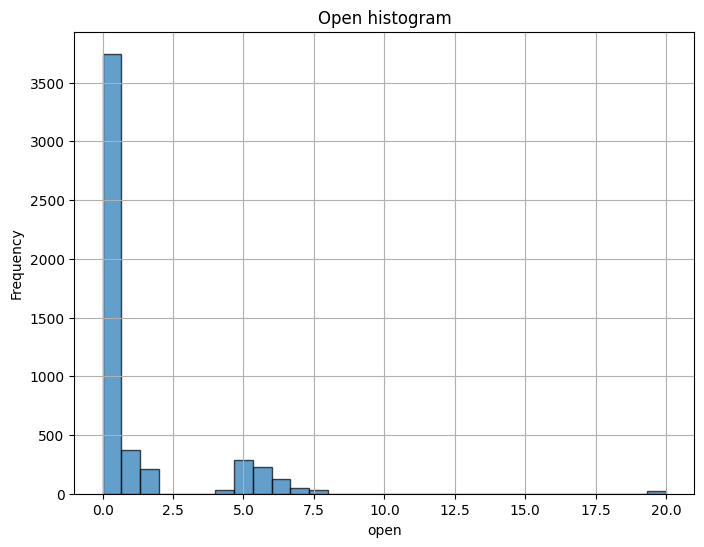

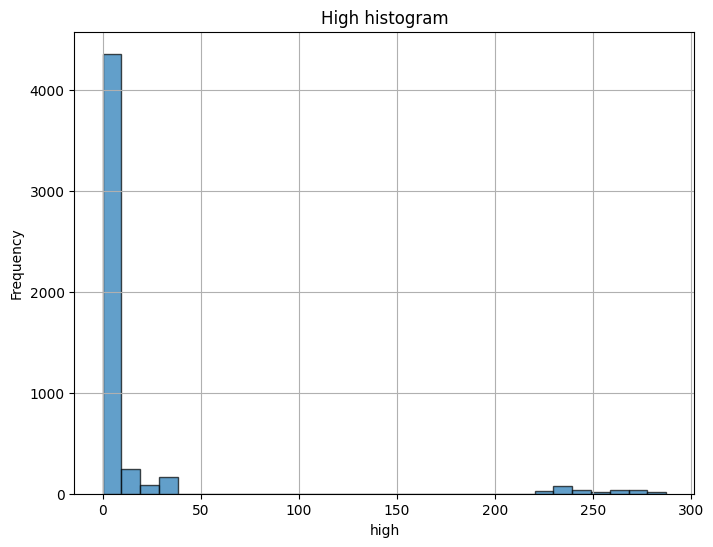

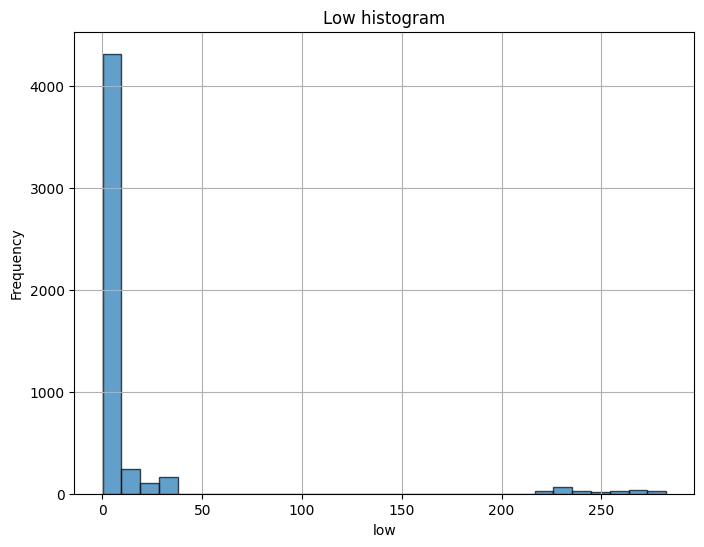

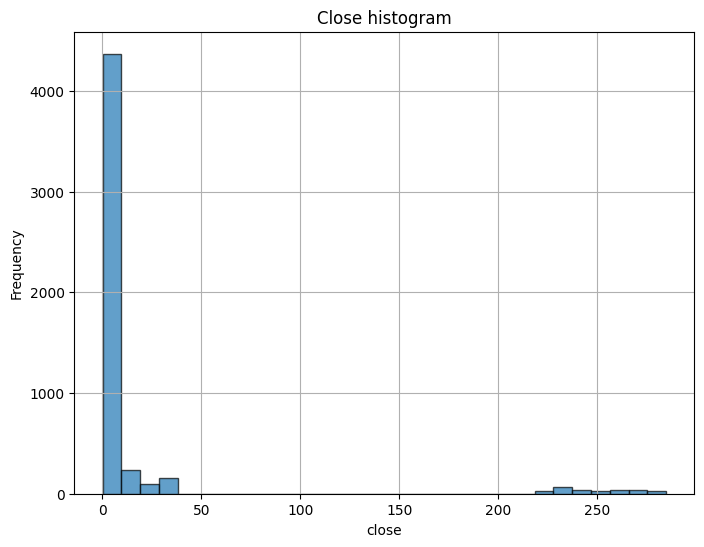

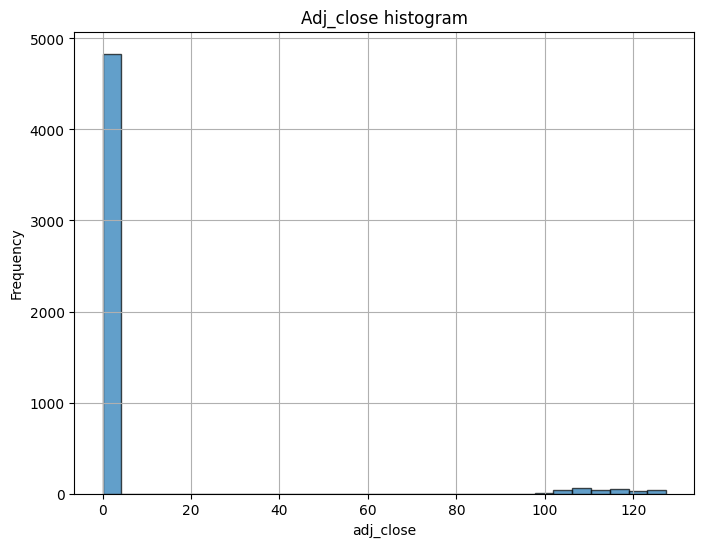

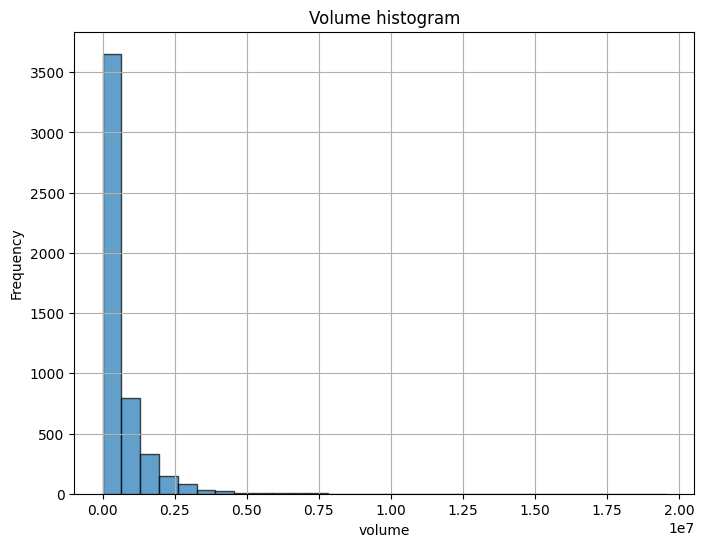

In [14]:
df_parquet_num = ['open', 'high', 'low', 'close', 'adj_close', 'volume']
pandas_df = df_parquet.select(df_parquet_num).toPandas()   

generate_multi_hist(pandas_df, df_parquet_num)

> ℹ️ **Instructions** ℹ️
>
> Investigate the **open** column to identify stocks that have open values greater than 2, and note any anomalies that you find in the data.
>
>*You may use as many coding cells as necessary.*

In [21]:
df_filtered = df_parquet.filter(df_parquet['open'] > 2)

In [63]:
df_filtered.describe().show()
# df_filtered.toPandas().describe()

+-------+------------------+------------------+------------------+------------------+------------------+------------------+-----+
|summary|              open|              high|               low|             close|         adj_close|            volume|stock|
+-------+------------------+------------------+------------------+------------------+------------------+------------------+-----+
|  count|               779|               779|               779|               779|               779|               779|  779|
|   mean| 6.074912513174662| 5.573487404834322|  5.46130268258522| 5.509041005747921|1.0024100287849698| 532115.2759948652| NULL|
| stddev|2.5409119039926433|1.0699638669305778|1.0707436884634807|1.0681113823626924|0.4432436231509917|1001982.5426980964| NULL|
|    min|              4.08|         1.0722656|         1.0605469|         1.0605469|       0.010166899|              8600|   AA|
|    max|              20.0|          7.713333|         7.6266665|          7.693333|     

In [64]:
# Get the 90th, 95th, and 98th percentiles of datasets of the 'open' column
percentile = df_filtered.approxQuantile("open", [0.25, 0.5, 0.75, 0.9, 0.95, .98], 0.01)
percentile

[5.106821537017822,
 5.505060195922852,
 6.05556583404541,
 7.133333206176758,
 7.366666793823242,
 20.0]

In [49]:
# 98th percentile
p98 = percentile[-1]
p98

20.0

In [139]:
def generate_hist(df, title):
    plt.figure(figsize=(10, 6))
    plt.hist(df['open'].dropna(), bins=30, edgecolor='black', alpha=0.7)
    plt.title(title)
    plt.xlabel('Open Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

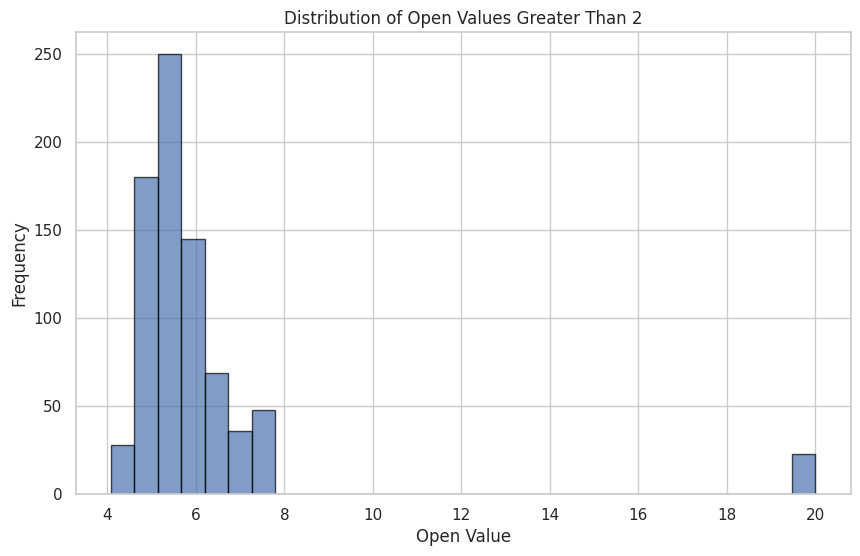

In [141]:
pdf_filtered = df_filtered.toPandas()
title = 'Distribution of Open Values Greater Than 2'
generate_hist(pdf_filtered, title)

 ## 📔️**Notes** 📔️

 *Use this cell to note down any potential findings.*

 1. 98% of the data is evenly distributed between 4 and 8.
 2. Only 2% of the stocks open at $20
 

> ℹ️ **Instructions** ℹ️
>
> Investigate **high**, **low**, **close**, and **adj_close** to determine if any stocks may be deviating from the normal ranges of the data set. Note down the stock(s) that you come across.
>
>*You may use as many coding cells as necessary.*

In [89]:
df_parquet_sub = ['high', 'low', 'close', 'adj_close']
pandas_df = df_parquet.select(df_parquet_sub)
# pandas_df = df_parquet.select(df_parquet_sub).toPandas()
pandas_df.describe().show()

+-------+------------------+------------------+-----------------+-----------------+
|summary|              high|               low|            close|        adj_close|
+-------+------------------+------------------+-----------------+-----------------+
|  count|              5106|              5064|             5106|             5085|
|   mean|16.757624946793637|15.728619917198033|16.64199179044607|5.986642513535306|
| stddev| 53.91407348193546| 51.32292289814399|53.54677139900802|24.64637054715319|
|    min|               0.0|       0.052377883|      0.053624976|     4.0381454E-7|
|    max|             287.5|             282.5|            285.0|        127.45936|
+-------+------------------+------------------+-----------------+-----------------+



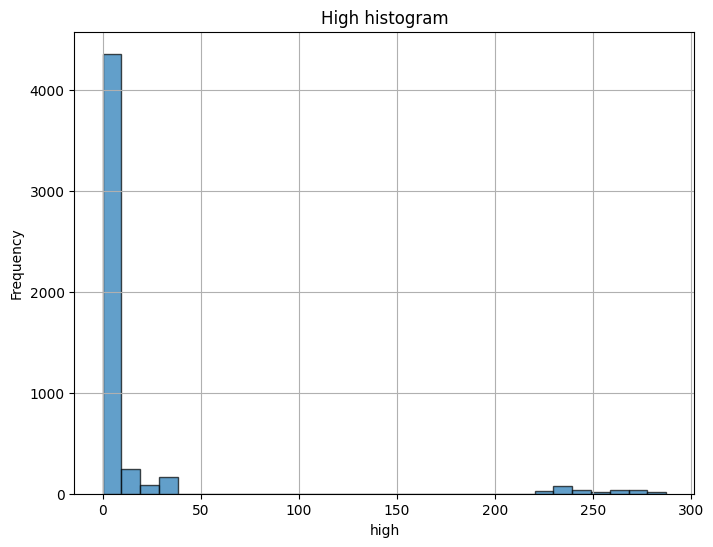

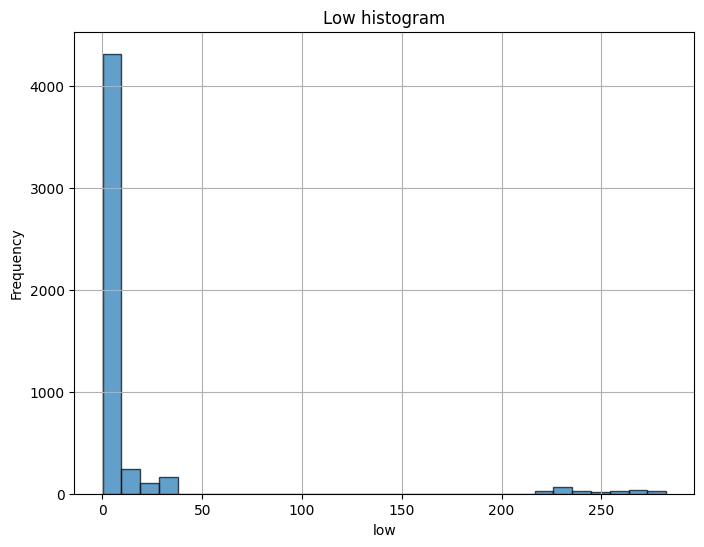

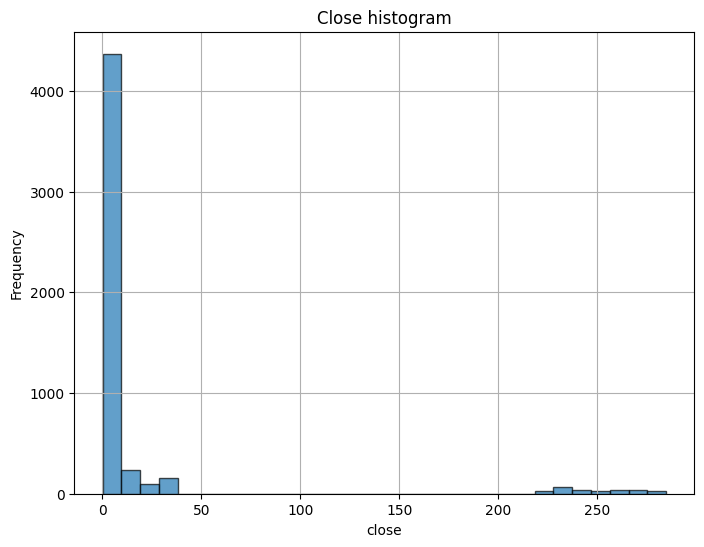

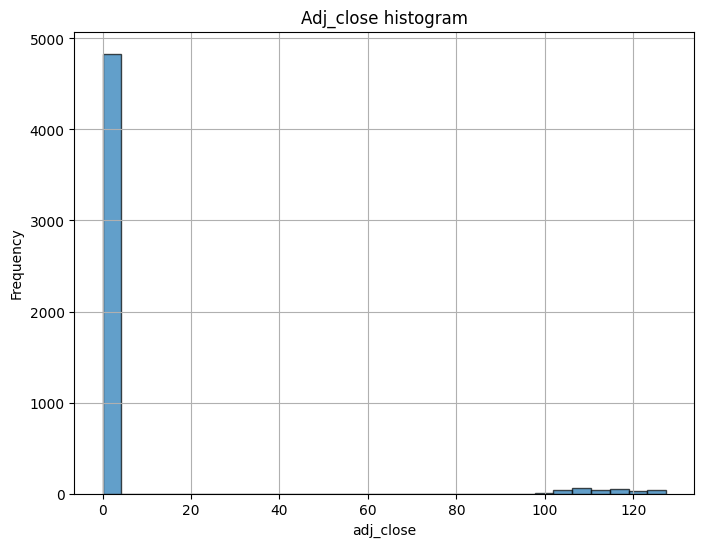

In [69]:
# Histograms
df_sub_plot = df_parquet.select(df_parquet_num).toPandas()
generate_multi_hist(df_sub_plot, df_parquet_sub)

In [101]:
# Get the 90th, 95th, and 97th percentiles of datasets of the 'open' column
for column in pandas_df.columns: 
    percentile = pandas_df.approxQuantile(column, [0.9, 0.95, .97], 0.01)
    print(f'Only 3% of the "{column}" column dataset is above {percentile[-1]}')

Only 3% of the "high" column dataset is above 231.875
Only 3% of the "low" column dataset is above 227.5
Only 3% of the "close" column dataset is above 231.25
Only 3% of the "adj_close" column dataset is above 106.59024810791016


 ## 📔️**Notes** 📔️

 *Use this cell to note down any potential findings.*

 1. 75% of the stocks trade below $7.
 2. Only 3% of the stocks trade above 200



## Completeness

Completeness is the proportion of stored data against the potential of “100% complete". This is the degree to which the required data is in the dataset. 

Does the dataset have missing values, or if it is time-series data, does it have time period gaps? Has a bias been introduced that may change your assumptions or affect your results?

Completeness issues can occur at the row level (gaps within the dataset) or the field level (one entry missing). At the field level, entire fields can being empty, or >80% of a field's data missing. 

Another issue that may occur is default values. A typical example of this is where a logger sends back a 0 instead of a null value, which can greatly skew any attempts at modelling. This is where it is instrumental to employ domain knowledge when assessing a dataset. 

- **Measured by**: A measure of the absence of blank (null) values or the presence of non-blank values;
- **Units**: Percentage;
- **Related to**: Validity and Accuracy.

### Missing values

> ℹ️ **Instructions** ℹ️
>
> Write code to identify and count the number of missing values (nulls) in the dataset. Include a percentage to describe the proportion of missing values per column. Output the results in the following manner:
>
> `There are <number_of_missing_values> (<percentage>) null values in <column_name> column`
>
>*You may use as many coding cells as necessary.*

In [10]:
# Get the number of missing values in each column
null_counts = df_parquet.select([F.sum(F.col(column).isNull().cast("int")).alias(column) for column in df_parquet.columns])
null_counts.show()

+----+----+----+---+-----+---------+------+-----+
|date|open|high|low|close|adj_close|volume|stock|
+----+----+----+---+-----+---------+------+-----+
|   0|   0|   0| 42|    0|       21|    21|    0|
+----+----+----+---+-----+---------+------+-----+



In [27]:
num_of_rows = df_parquet.count()

null_percentage = null_counts.select(
    [F.round((F.col(column) / num_of_rows * 100),2).alias(column) for column in null_counts.columns]
)

null_percentage.show()

+----+----+----+----+-----+---------+------+-----+
|date|open|high| low|close|adj_close|volume|stock|
+----+----+----+----+-----+---------+------+-----+
| 0.0| 0.0| 0.0|0.82|  0.0|     0.41|  0.41|  0.0|
+----+----+----+----+-----+---------+------+-----+



In [31]:
# Collect the null counts and percentages as dictionaries
null_counts_dict = null_counts.collect()[0].asDict()
null_percentage_dict = null_percentage.collect()[0].asDict()


# Output the results
for column in df_parquet.columns:
    count = null_counts_dict[column]
    percentage = null_percentage_dict[column]
    print(f"There are {count} ({percentage:.2f}%) null values in {column} column")

There are 0 (0.00%) null values in date column
There are 0 (0.00%) null values in open column
There are 0 (0.00%) null values in high column
There are 42 (0.82%) null values in low column
There are 0 (0.00%) null values in close column
There are 21 (0.41%) null values in adj_close column
There are 21 (0.41%) null values in volume column
There are 0 (0.00%) null values in stock column


### Columns with missing values


> ℹ️ **Instructions** ℹ️
>
> From the above result, probe the columns that are affected by the missing data to find out which stocks were affected.
>
>*You may use as many coding cells as necessary.*

In [34]:
columns_with_missing_data = [column for column, count in null_counts_dict.items() if count > 0]
columns_with_missing_data

['low', 'adj_close', 'volume']

In [36]:
# Function to find affected stocks for a given column
def find_affected_stocks(df, column):
    affected_stocks = df.filter(F.col(column).isNull()).select("stock").distinct()
    return [row.stock for row in affected_stocks.collect()]

# Dictionary to store affected stocks for each column with missing data
affected_stocks_dict = {column: find_affected_stocks(df_parquet, column) for column in columns_with_missing_data}

# Output the affected stocks
for column, stocks in affected_stocks_dict.items():
    print(f"Stocks affected by missing values in {column} column: {stocks}")

Stocks affected by missing values in low column: ['CAT', 'NAV']
Stocks affected by missing values in adj_close column: ['FL']
Stocks affected by missing values in volume column: ['JNJ']


#### Fix Completeness

How do we deal with incomplete data?
- Dropping missing values
- Discard the incomplete column
- Discard the rows containing missing data
- Case deletion

> ℹ️ **Instructions** ℹ️
>
> Use the appropriate strategy to remedy the missing data. 
>
>*You may use as many coding cells as necessary.*

In [103]:
# The missing values are < 1% of the data in each column therefore the rows with missing data will be droped 

df_parquet_copy = df_parquet
df_dropna = df_parquet_copy.na.drop()

In [15]:
# # Show the resulting DataFrame
null_counts = df_dropna.select([F.sum(F.col(column).isNull().cast("int")).alias(column) for column in df_dropna.columns])
null_counts.show()

+----+----+----+---+-----+---------+------+-----+
|date|open|high|low|close|adj_close|volume|stock|
+----+----+----+---+-----+---------+------+-----+
|   0|   0|   0|  0|    0|        0|     0|    0|
+----+----+----+---+-----+---------+------+-----+



### Zero Values

Take a deeper look into the entries with many zero values.

#### Fix Completeness

Completeness issues can be fixed through imputation of the missing data through:
- imputation by mean/mode/median;
- regression; or
- KNN.
 
> ℹ️ **Instructions** ℹ️
>
> Write code to identify and count the number of zeros (0) in the dataset. Include a percentage to describe the proportion of missing values per column. Output the results in the following manner:
>
> `There are <number_of_zeros> (<percentage>) zero values in <column_name> column`
>
>*You may use as many coding cells as necessary.*

In [23]:
# Define a list of columns to check for zeros
columns_to_check = [column for column in df_dropna.columns if column not in ["date", "stock"]]

# Count the number of zero values in each column
zero_counts = df_dropna.select([F.sum(F.when(F.col(column) == 0, 1).otherwise(0)).alias(column) for column in columns_to_check])

In [24]:
# Collect the zero counts as a dictionary
zero_counts_dict = zero_counts.collect()[0].asDict()
zero_counts_dict

{'open': 2706, 'high': 20, 'low': 0, 'close': 0, 'adj_close': 0, 'volume': 27}

In [25]:
# Calculate the percentage of zero values per column
total_rows = df_dropna.count()
zero_percentage_dict = {column: (count / total_rows) * 100 for column, count in zero_counts_dict.items()}

In [26]:
# Output the results
for column, count in zero_counts_dict.items():
    percentage = zero_percentage_dict[column]
    print(f"There are {count} ({percentage:.2f}%) zero values in {column} column")

There are 2706 (53.88%) zero values in open column
There are 20 (0.40%) zero values in high column
There are 0 (0.00%) zero values in low column
There are 0 (0.00%) zero values in close column
There are 0 (0.00%) zero values in adj_close column
There are 27 (0.54%) zero values in volume column


From the above section, you find that there are a few columns that contain zero values. However, some of these are true zeros and are explainable. Your task is to distinguish which column should undergo data imputation.

> ℹ️ **Instructions** ℹ️
>
> Investigate the columns with zero values and determine which one should undergo data imputation. Take note of the stock and month on which zero values occurred.
>
>*You may use as many coding cells as necessary.*

In [31]:
for column in columns_to_check:
    if zero_counts_dict[column] > 0:
        print(f"\nExamining zero values in {column} column:")
        zero_rows = df_dropna.filter(F.col(column) == 0).select("date", "stock").withColumn("month", F.month("date"))
        zero_rows.show()


Examining zero values in open column:


+----------+-----+-----+
|      date|stock|month|
+----------+-----+-----+
|1962-02-19|  CVX|    2|
|1962-02-19|  DTE|    2|
|1962-02-19|   ED|    2|
|1962-02-19|   FL|    2|
|1962-02-19|   GT|    2|
|1962-02-19|   IP|    2|
|1962-02-19|  JNJ|    2|
|1962-02-19|   MO|    2|
|1962-02-19|  NAV|    2|
|1962-02-19|   PG|    2|
|1962-02-19|  XOM|    2|
|1962-02-14|  CVX|    2|
|1962-02-14|  DTE|    2|
|1962-02-14|   ED|    2|
|1962-02-14|   FL|    2|
|1962-02-14|   GT|    2|
|1962-02-14|   IP|    2|
|1962-02-14|  JNJ|    2|
|1962-02-14|   MO|    2|
|1962-02-14|  NAV|    2|
+----------+-----+-----+
only showing top 20 rows


Examining zero values in high column:


+----------+-----+-----+
|      date|stock|month|
+----------+-----+-----+
|1962-11-05|  CAT|   11|
|1962-11-12|  CAT|   11|
|1962-11-08|  CAT|   11|
|1962-11-01|  CAT|   11|
|1962-11-29|  CAT|   11|
|1962-11-28|  CAT|   11|
|1962-11-30|  CAT|   11|
|1962-11-26|  CAT|   11|
|1962-11-02|  CAT|   11|
|1962-11-21|  CAT|   11|
|1962-11-15|  CAT|   11|
|1962-11-16|  CAT|   11|
|1962-11-20|  CAT|   11|
|1962-11-09|  CAT|   11|
|1962-11-19|  CAT|   11|
|1962-11-23|  CAT|   11|
|1962-11-27|  CAT|   11|
|1962-11-14|  CAT|   11|
|1962-11-13|  CAT|   11|
|1962-11-07|  CAT|   11|
+----------+-----+-----+


Examining zero values in volume column:
+----------+-----+-----+
|      date|stock|month|
+----------+-----+-----+
|1962-05-18|  XOM|    5|
|1962-05-24|  XOM|    5|
|1962-09-28|  JNJ|    9|
|1962-05-08|  XOM|    5|
|1962-01-02|  JNJ|    1|
|1962-05-14|  XOM|    5|
|1962-05-28|  XOM|    5|
|1962-05-25|  XOM|    5|
|1962-05-29|  XOM|    5|
|1962-05-02|  XOM|    5|
|1962-05-31|  XOM|    5|
|1962-05

In [59]:
# Filter the DataFrame for CAT stock
df_cat = df_dropna.filter(F.col("stock") == "CAT")

# Get the summary statistics for the high column
summary_stats_cat_high = df_cat.describe("high")

# Show the summary statistics
summary_stats_cat_high.show()


+-------+------------------+
|summary|              high|
+-------+------------------+
|  count|               230|
|   mean|1.3670855973077858|
| stddev|0.4444197973698395|
|    min|               0.0|
|    max|         1.7708334|
+-------+------------------+



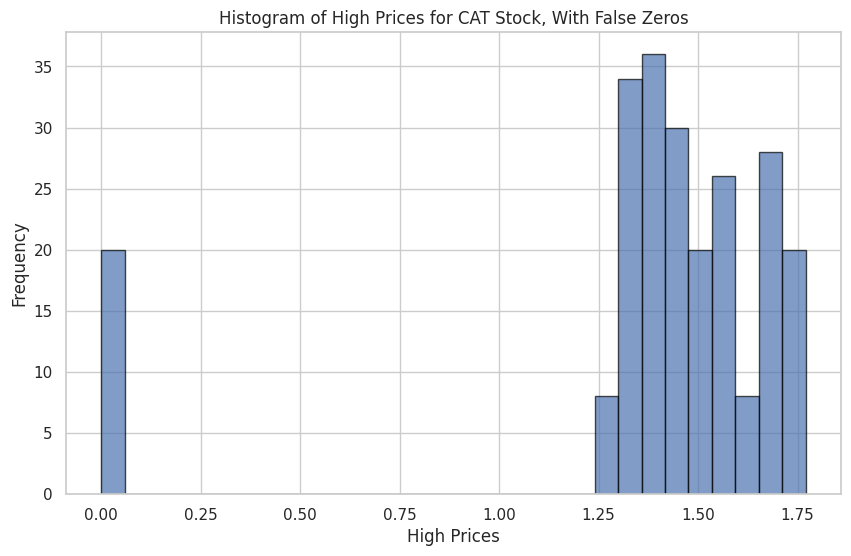

In [148]:
# Filter the DataFrame for CAT stock and collect the high column data
cat_high_data = df_cat.select("high").rdd.flatMap(lambda x: x).collect()

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(cat_high_data, bins=30, edgecolor='black', alpha=0.7)
plt.title('Histogram of High Prices for CAT Stock, With False Zeros')
plt.xlabel('High Prices')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

**The CAT stock requires data imputation in the high column of November 1962.**
>
> In November, zeros appear only in the "high (maximum price during the day)" column.
>
> This suggests that on those particular days, the low price was higher than the high price, which is illogical.
>
> The histogram also shows values ranging between 1.25 and 1.75. Additionally, the 20 false zero entries for November are visible on the left side of the graph.

**Zero Entries in the Open Column**
>
>Stocks with zero entries in the "open" column do not have zero entries in the "high" and "volume" columns. This indicates that the "high" and "volume" values are greater than zero on those particular days and therefore true.

**XOM Stock Volume in May 1962**
>
> In May 1962, the trading volume for XOM was zero on most days.
> However, these zeros do not appear in the "open" and "high" columns.
> This suggests that the zero volumes are true values, indicating no trading activity on those particular days.

> ℹ️ **Instructions** ℹ️
>
> Once you have identified the column that needs to undergo imputation, update the values for the affected records by using the average value for the affected stock.
>
>*You may use as many coding cells as necessary.*

**The high column summary statistics for CAT indicate a mean of 1.36. However, this figure includes false zero entries from November 1962. Therefore, the true mean of this column should exclude these zero entries.**

In [105]:
# Filter the DataFrame for CAT stock and high column non-zero values
df_cat_high_non_zero = df_dropna.filter((F.col("stock") == "CAT") & (F.col("high") != 0))
df_cat_high_non_zero.describe().show()

+-------+-------------------+-------------------+-------------------+-------------------+--------------------+-----------------+-----+
|summary|               open|               high|                low|              close|           adj_close|           volume|stock|
+-------+-------------------+-------------------+-------------------+-------------------+--------------------+-----------------+-----+
|  count|                210|                210|                210|                210|                 210|              210|  210|
|   mean| 1.4796130992117382|  1.497284225622813| 1.4625000022706531|  1.478695437454042|  0.1281465702113651|172994.2857142857| NULL|
| stddev|0.14504910720640965|0.14329073387941013|0.14480423423137262|0.14481484455602614|0.011897403105197832|84334.09275992992| NULL|
|    min|           1.234375|               1.25|          1.2291666|           1.234375|         0.106719546|            16800|  CAT|
|    max|               1.75|          1.7708334|      

In [67]:
# Calculate the mean of the high column for CAT
mean_high_cat = df_cat_high_non_zero.agg(F.mean("high").alias("mean_high")).collect()[0]["mean_high"]
mean_high_cat

1.497284225622813

### High column after data imputation

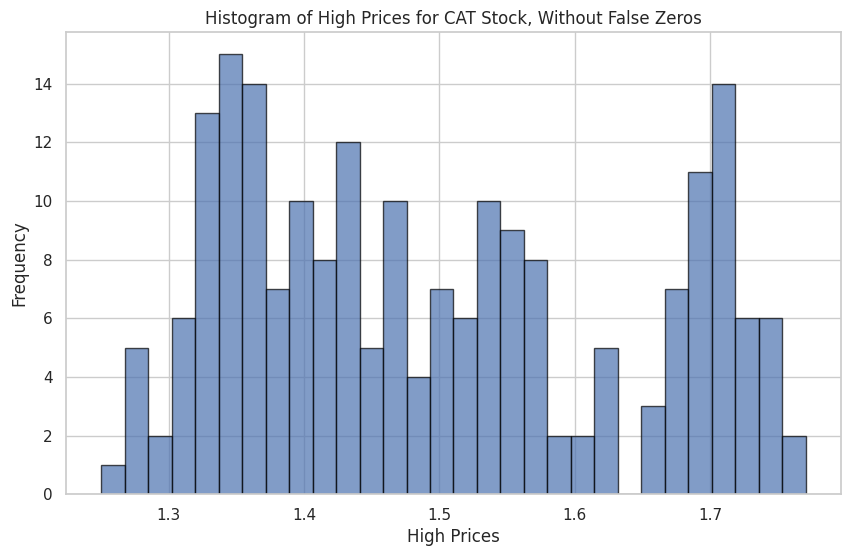

In [149]:
# Filter the DataFrame for CAT stock (Without false zeros) and collect the high column data
cat_high_data = df_cat_high_non_zero.select("high").rdd.flatMap(lambda x: x).collect()

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(cat_high_data, bins=30, edgecolor='black', alpha=0.7)
plt.title('Histogram of High Prices for CAT Stock, Without False Zeros')
plt.xlabel('High Prices')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [90]:
# Replace zero values in the high column for CAT in the month of November
df_cat_high_non_zero_copy = df_cat_high_non_zero
df_new = df_dropna

df_imputed = df_new.withColumn(
    "high",
    F.when((F.col("stock") == "CAT") & (F.month(F.col("date")) == 11) & (F.col("high") == 0), mean_high_cat).otherwise(F.col("high"))
)

### Summary Statistics of the imputed DataFrame
**Showing a minimun 'high' price of 0.055**

In [92]:
df_imputed.describe().show()

+-------+------------------+------------------+------------------+------------------+-----------------+-----------------+-----+
|summary|              open|              high|               low|             close|        adj_close|           volume|stock|
+-------+------------------+------------------+------------------+------------------+-----------------+-----------------+-----+
|  count|              5022|              5022|              5022|              5022|             5022|             5022| 5022|
|   mean|1.1014219280169133|16.034782354493565|15.836436763646883|15.915820842197855|5.606189711274126|546946.4157706093| NULL|
| stddev|2.3807362974077337| 52.37890734439906| 51.52295147206575|  52.0129707627932|23.83142762579132| 868294.708934432| NULL|
|    min|               0.0| 0.054872065782547|       0.052377883|       0.053624976|     4.0381454E-7|                0|   AA|
|    max|              20.0|             287.5|             282.5|             285.0|        127.45936| 


## Consistency

Consistency is the absence of difference when comparing two or more representations of a thing against a reference.

Data entries that refer to the same record or entity have to be consistent across all entries, e.g., if you are dealing with records from a logger in the field, the entries for that logger have to remain consistent, and the name or primary key of that logger cannot change from one entry to another. 

For example, 'Logger1', 'Loger1' and 'Logge1' are examples of inconsistent keys. 

This is not just within a single table but also becomes more important if you are dealing with relational data. In which case, the mappings between tables and systems must be consistent. If not, the relationships will be completely lost between the tables and referential integrity compromised. 

- **Measured by**: Analysis of pattern and/or value frequency;
- **Units**: Percentage;
- **Related to**: Accuracy, Validity, and Uniqueness.

> ℹ️ **Instructions** ℹ️
>
> There currently exists a stock that has inconsistent naming. Make use of the metadata to determine which stock is inconsistently named, then update the dataframe appropriately to get rid of this inconsistency.
>
>*You may use as many coding cells as necessary.*

In [ ]:
#TODO: Write your code here

## Timeliness

Timeliness is the degree to which data represent reality from the required point in time.

Timeliness expects that the data within your dataset is sufficiently up to date. If you are trying to answer questions that relate to recent problems, having timely data is extremely important. For example, you cannot use current flight patterns to model how many aeroplanes will be required by a large aeronautics company within the next 5-10 years. 

Similarly, when answering questions that require real-time answers (e.g., predicting when a pipe will burst in a manufacturing plant), you have to be set up to receive real-time data from sensors and loggers. 

- **Measured by**: Time difference;
- **Units**: Time;
- **Related to**: Accuracy because it will decay as time progress. 

It is important to see the latest value for each of the stocks that we are looking at:

In [44]:
df.groupBy('stock').agg(F.max('Date')).show()

+-----+----------+
|stock| max(Date)|
+-----+----------+
|   AA|1962-12-31|
|  XOM|1962-12-31|
|  DIS|1962-12-31|
|   PG|1962-12-31|
|   GT|1962-12-31|
|   MO|1962-12-31|
|  IBM|1962-12-31|
|  JNJ|1962-12-31|
|  CVX|1962-12-31|
|  DTE|1962-12-31|
|   BA|1962-12-31|
|   GE|1962-12-31|
|  HPQ|1962-12-31|
| ARNC|1962-12-31|
|  CAT|1962-12-31|
|   IP|1962-12-31|
|   FL|1962-12-31|
|   ED|1962-12-31|
|  NAV|1962-12-31|
|   KO|1962-12-31|
+-----+----------+



Sometimes, some of these axes of data quality will be less important than others. 
This is one of those cases where it is less important to have timely data, since 
we are trying to create a training dataset for a stock market prediction algorithm. 

It is important to know the context in which you are doing your modelling. 

### Gaps in the dataset

Let's see if we can find inconsistencies in the time series by having a look at the number of entries for each of the tickers.
 
> ℹ️ **Instructions** ℹ️
>
> Uncomment and use the below code to determine which dates had entries that were not equal to 20. You may have to change the name of the dataframe to see the resultant output
>
>*You may use as many coding cells as necessary.*

In [ ]:
#df.orderBy('date').groupby('date').count().where(F.col('count') != 20).show(400)

> ℹ️ **Instructions** ℹ️
>
> From the above result, investigate the number of times a stock appears for the given month. You can infer the months by using the output of the previous cell.
>
>*You may use as many coding cells as necessary.*

In [ ]:
#TODO: Write your code here

## Uniqueness

Uniqueness requires that nothing will be recorded more than once based upon how that thing is identified. It is the inverse of an assessment of the level of duplication.

Each entry within the dataset should only relate to a single event that has occurred and thus should not be duplicated. This is largely mediated by having the appropriate primary key, which means sticking to the requirements of a good primary key. All fields in the tables should be non-transitively dependent on the primary key.

As such, deduplication of the dataset may be required. 

- **Measured by**: Analysis of the number of things assessed in the “real world” compared to the number of records of things in the dataset. This requires a reference dataset which is the ground truth;
- **Units**: Percentage;
- **Related to**: Consistency.

### Duplication Test
For time-series data, it is important to check for duplications, as we typically expect all values to be unique within the dataset.

The first thing to check will be if the primary key values within the dataset are unique - in our case, that will be a combination of the stock name and the date.

Secondly, we want to check if the entries are all unique, which is done by checking for duplicates across that whole dataset.

> ℹ️ **Instructions** ℹ️
>
> Write code to determine if there are any duplicates within the data, and then proceed to correct this by dropping them from the dataframe.
>
>*You may use as many coding cells as necessary.*

In [ ]:
#TODO: Write your code here

## Validity
Data is valid if it conforms to the syntax (format, type, range) of its definition.

Certain values within a field may have specific criteria required to make it valid, e.g., numerical columns cannot contain alphabetical characters, which can occur due to scientific notation.

This can be more difficult to determine in stings, in which case you may have to check using regex. 

- **Measured by**: Comparison between the data and metadata or documentation for the data item;
- **Units**: Percentage of data items deemed Valid or Invalid;
- **Related to**: Accuracy, Completeness, Consistency, and Uniqueness.

We need to first define what we expect from our dataset:

- stock: string (nullable = true) => Should be contained in the list of expected tickers
- date: date (nullable = true) => Should conform to date format, and be in the past
- open: double (nullable = true) => Should be positive or 0
- high: double (nullable = true) => Should be positive or 0
- low: double (nullable = true) => Should be positive or 0 (should be < high)
- close: double (nullable = true) => Should be positive or 0 (should be <= high )
- adj_close: double (nullable = true) => Should be positive or 0
- volume: integer (nullable = true) => Should be positive or 0
- high_avg: double (nullable = true) => Derived (not needed to test)
- high_imp: double (nullable = true) => Derived (not needed to test)
- day_of_week: string (nullable = true) => Derived (not needed to test)

*Is there any other logic that we can incorporate?*

> ℹ️ **Instructions** ℹ️
>
> Use the metadata to check if all the stocks in your current dataframe are valid. In other words, make sure you have no foreign/unknown tickers in your dataframe.
>
>*You may use as many coding cells as necessary.*


In [ ]:
#TODO: Write your code here

> ℹ️ **Instructions** ℹ️
>
>
>Check if the date column contains only valid dates and all dates are in the past.
>
>*Valid dates should already be checked in the data reading step.*

In [ ]:
#TODO: Write your code here

> ℹ️ **Instructions** ℹ️
>
>Check that all of numerical columns are positive.

In [ ]:
#TODO: Write your code here

### Save Updates

With our initial work of checking the various dimensions of the data quality completed, we can now save these results to a CSV file.  

In [67]:
pd_df = df.toPandas()

In [68]:
pd_df.to_csv('./<name>_<surname>_data_profiling.csv')